In [26]:
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.manifold import TSNE
import pickle as pkl
import pandas as pd

with open('../data/stopwords.txt', 'r') as f:
    STOP_WORDS = f.read().splitlines()

TOPIC_COLUMN = "content"
DATABASE_PATH = '../data/database.csv'
"""Create a corpus of all the articles."""
database = pd.read_csv(DATABASE_PATH)
database = database.loc[database[TOPIC_COLUMN].notna()]
param_set = {
    "stop_words": STOP_WORDS,
    "ngram_range": (1, 2),
    "max_df": 0.95,
    "min_df": 2,
    "max_features": 10000,
}
print("Extracting tf features for LDA...")
tfidf_vectorizer = TfidfVectorizer(**param_set)
tfidf = tfidf_vectorizer.fit_transform(database[TOPIC_COLUMN])
tfidf_feat_names = tfidf_vectorizer.get_feature_names()

counter = CountVectorizer(**param_set)
tf = counter.fit_transform(database[TOPIC_COLUMN])
tf_feat_names = counter.get_feature_names()
print("Fitting LDA models with tf features")
no_topics = 20
nmf = NMF(n_components=no_topics,
          random_state=1,
          alpha=.1,
          l1_ratio=.5,
          init='nndsvd').fit(tfidf)
lda = LatentDirichletAllocation(n_components=no_topics,
                                max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0).fit(tf)
# format topics\
top_words = 10


def format_topics_sentences(model, feat_names):
    topic_words = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_words[topic_idx] = [
            feat_names[i] for i in topic.argsort()[:-top_words - 1:-1]
        ]

    return topic_words


nmf_topic_words = format_topics_sentences(nmf, tfidf_feat_names)
lda_topic_words = format_topics_sentences(lda, tf_feat_names)
print("Runing TSNE")
tsne = TSNE(n_components=2, perplexity=35, n_iter=3000)
tsne_results = tsne.fit_transform(tfidf)
print("Saving results")
pkl.dump(
    {
        "nmf": nmf_topic_words,
        "lda": lda_topic_words,
        "X": tsne_results,
        "y_lda": lda.transform(tf).argmax(axis=1),
        "y_nmf": nmf.transform(tfidf).argmax(axis=1),
    }, open('../data/topics.pkl', 'wb'))


Extracting tf features for LDA...


/Users/jm/repos/fullstek-course/.stek/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Fitting LDA models with tf features


/Users/jm/repos/fullstek-course/.stek/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1477: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(


Runing TSNE


/Users/jm/repos/fullstek-course/.stek/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/jm/repos/fullstek-course/.stek/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Saving results


/Users/jm/repos/fullstek-course/.stek/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1477: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(


In [28]:
lda_topic_words

{0: ['usa',
  'energii',
  'mld',
  'inwestycje',
  'dostaw',
  'inwestycji',
  'amerykanie',
  'elektrowni',
  'waszyngton',
  'technologii'],
 1: ['ameryka',
  'świecie',
  'chin',
  'chiny',
  'rzecz',
  'strategii',
  'chodzi',
  'agendy',
  'sojuszników',
  'zasady'],
 2: ['pis',
  'granicy',
  'prezydenta',
  'partii',
  'sprawiedliwości',
  'prezydent',
  'prezesa',
  'prawa',
  'projekt',
  'kaczyński'],
 3: ['dolarów',
  'gavi',
  'gates',
  'szczepionek',
  'milionów',
  'covid',
  'organizacji',
  'milionów dolarów',
  'organizacje',
  'fundacja'],
 4: ['wp',
  'źródło',
  'zdjęcie',
  'masz',
  'filmik',
  'dziejesie',
  'filmik prześlij',
  'dziejesie wp',
  'newsa zdjęcie',
  'newsa'],
 5: ['wpolityce',
  'węgla',
  'wsparcia',
  'stronie',
  'dostępna',
  'powiązane tematy',
  'stronie autor',
  'dostępna stronie',
  'podziel',
  'tematy'],
 6: ['życia',
  'kościoła',
  'kościół',
  'ludzi',
  'tk',
  'sprawie',
  'źródło',
  'człowiek',
  'prawa',
  'swoich'],
 7: ['ukr

/Users/jm/repos/fullstek-course/.stek/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1477: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(


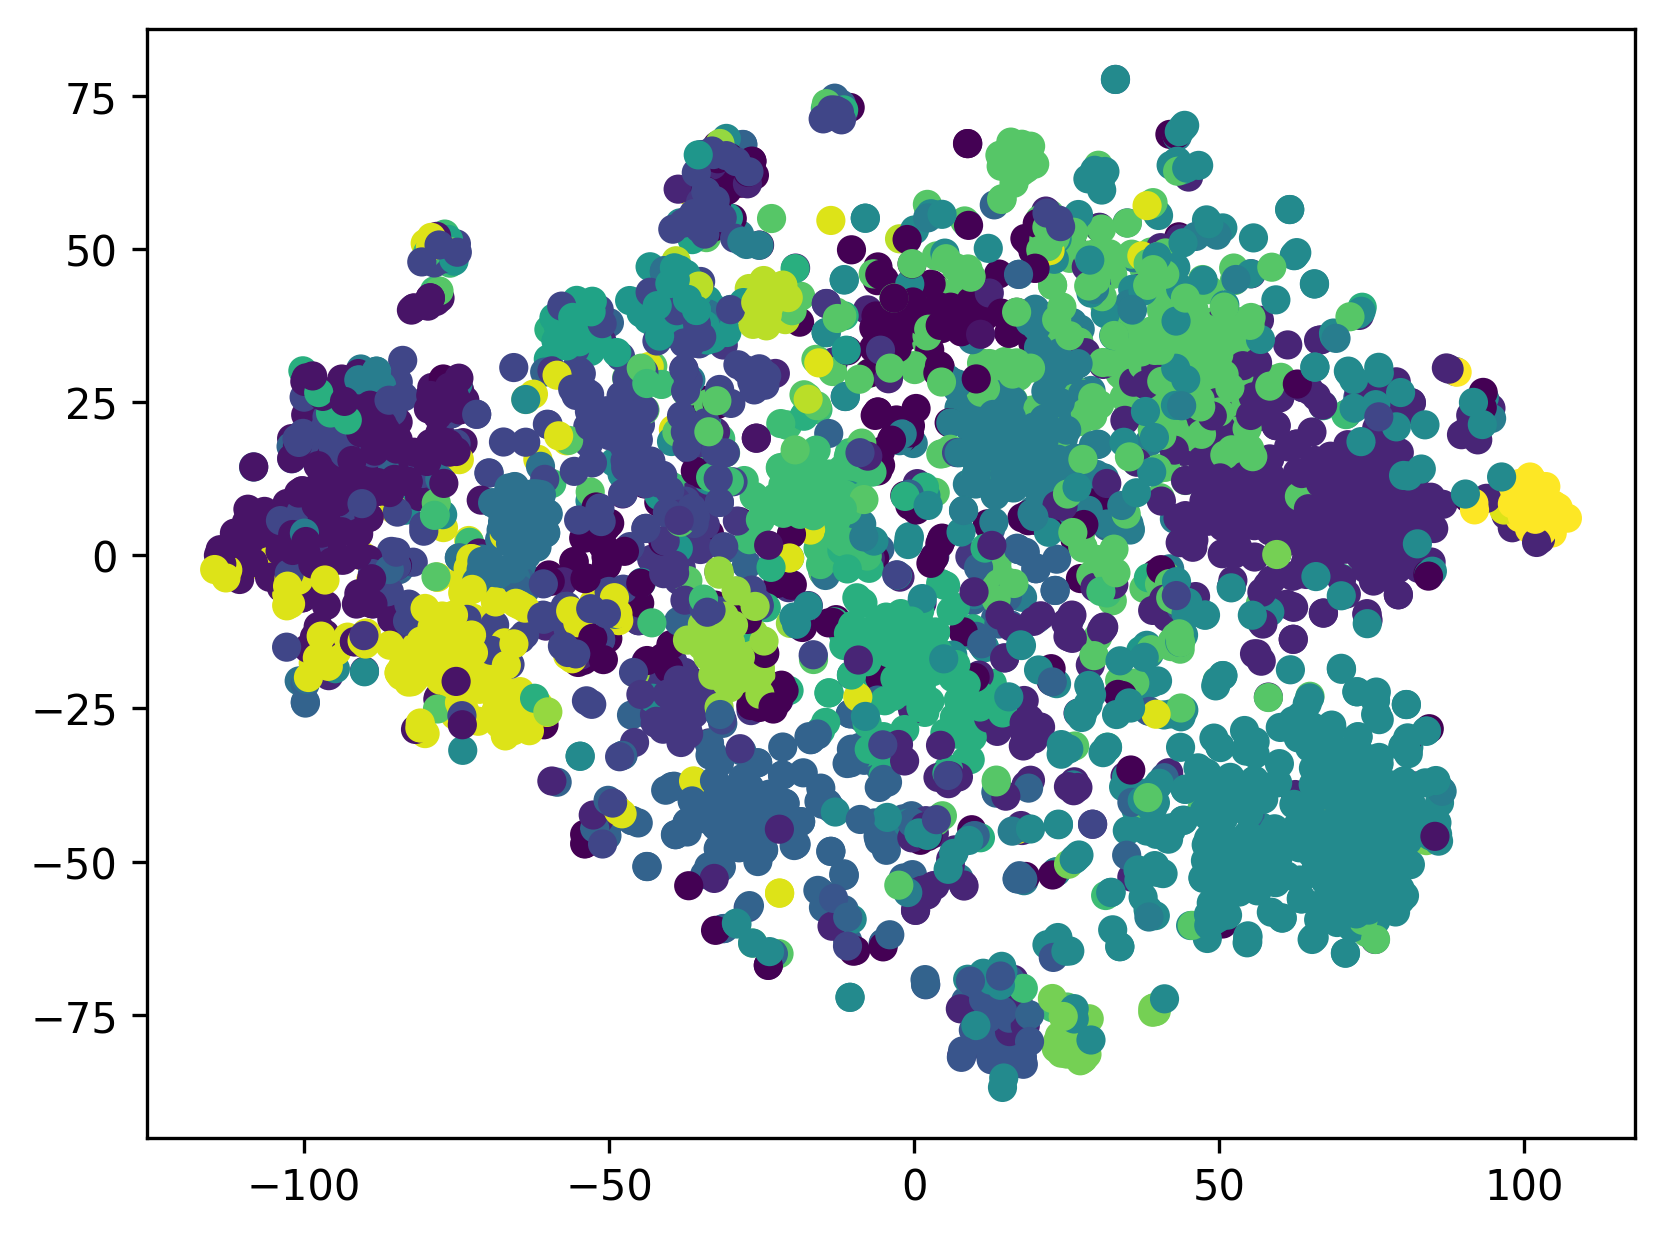

In [27]:
import matplotlib.pyplot as plt
# tsne = TSNE(n_components=2, perplexity=35, n_iter=3000)
# tsne_results = tsne.fit_transform(tfidf)
fig, ax = plt.subplots(dpi=300)
ax.scatter(
    tsne_results[:, 0],
    tsne_results[:, 1],
    # c=nmf.transform(tfidf).argmax(axis=1),
    c=nmf.transform(tf).argmax(axis=1),
)
